In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [4]:
def load_dataset(index):
    with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

4867


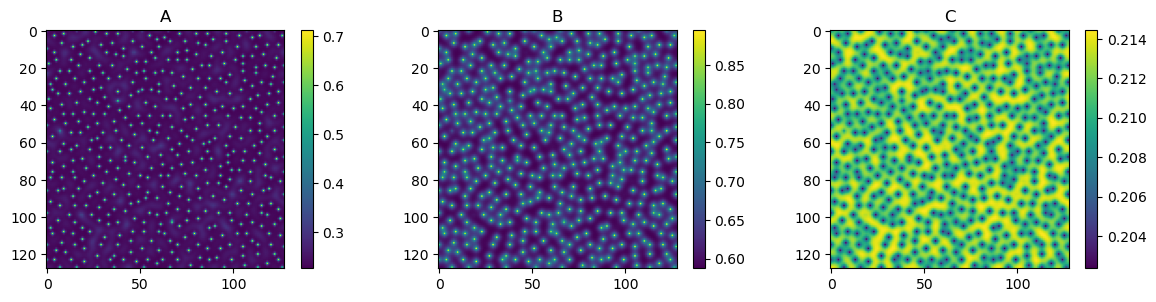

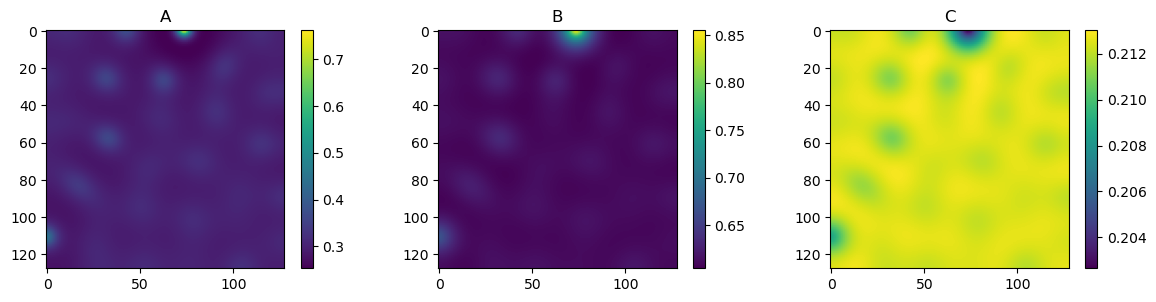

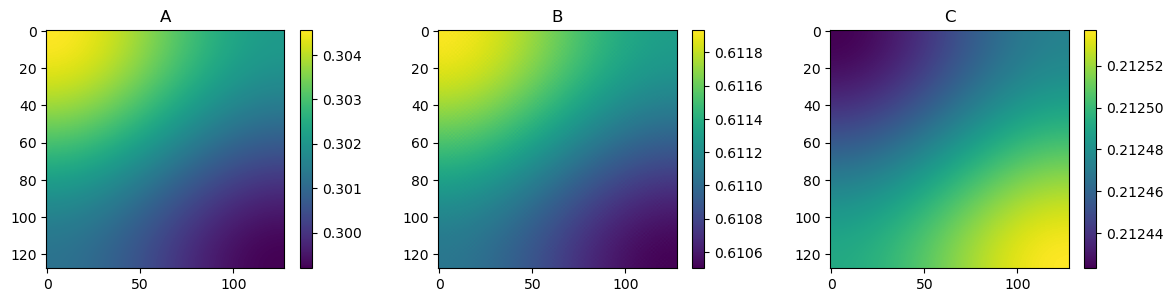

In [47]:
index = 10#2
print(indices[index])
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [48]:
T=1
L=50
if L == 50:
    res = res_128_50
elif L == 10:
    res = res_128_10
elif L == 1:
    res = res_128_1

data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(45, 100, 1)
y_slice = slice(45, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

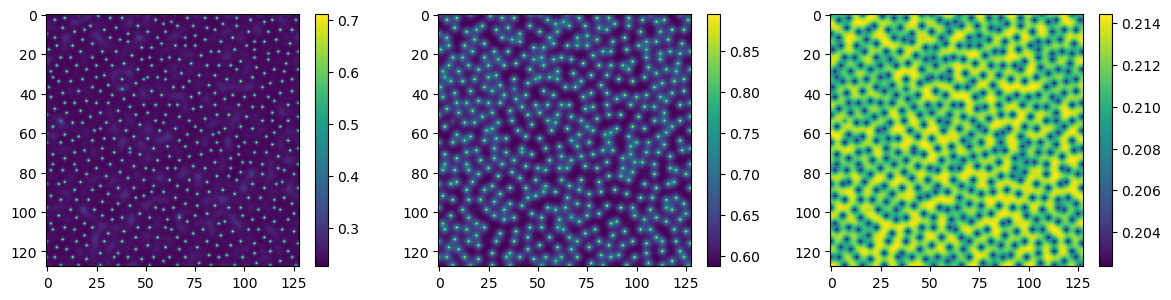

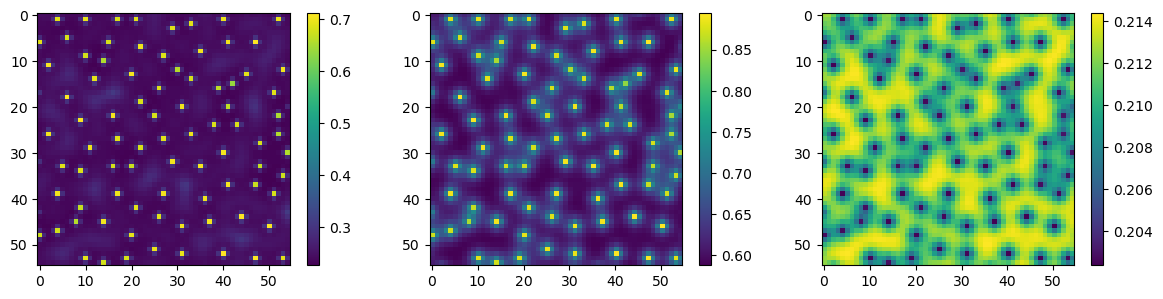

In [49]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [50]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [60]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 256, 256, 3],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=1,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    V_A = create_tf_var(V_A_val)
    V_B = create_tf_var(V_B_val)
    V_C = create_tf_var(V_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    K_AA = create_tf_var(K_AA_val)
    K_AB = create_tf_var(K_AB_val)
    K_AC = create_tf_var(K_AC_val)
    K_BA = create_tf_var(K_BA_val)
    K_BC = create_tf_var(K_BC_val)
    K_CB = create_tf_var(K_CB_val)
    K_CC = create_tf_var(K_CC_val)
    n = create_tf_var(n_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(V_A_val, V_A)
                    + as_tuple(V_B_val, V_B)
                    + as_tuple(V_C_val, V_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(K_AA_val, K_AA)
                    + as_tuple(K_AB_val, K_AB)
                    + as_tuple(K_AC_val, K_AC)
                    + as_tuple(K_BA_val, K_BA)
                    + as_tuple(K_BC_val, K_BC)
                    + as_tuple(K_CB_val, K_CB)
                    + as_tuple(K_CC_val, K_CC)
                   )
    globals()["index"]=0

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
        #print(act_A_laplacian.shape)
        act_A_laplacian = flatten(act_A_laplacian)
        #print(act_A_laplacian.shape)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(D_A*act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(D_B*act_B_laplacian/(dxdy))
        
        def to(arr):            
            return arr.numpy().reshape(53, 53)

        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                

            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))

            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))

            A_rhs = D_A * (A_xx + A_yy)# - u_t
            B_rhs = D_B * (B_xx + B_yy)# - v_t
            

            f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
            f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
            f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
            
            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)            

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + 
                  w3*l2_res_C +
                  w4*l2_res_A_rhs + w5*l2_res_B_rhs)
        
#         if globals()["index"]%1000==0:
#             plot_n_im([to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n)), 
#                        to(V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n))],
#                 ["C", "VC C"],          
#                 figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(A), to(B), to(C)],
#                ["A", "B", "C"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(act(A, K_AA, n)*inh(B, K_BA, n)), to(act(A, K_AB, n)*inh(C, K_CB, n)), to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n))],
#                ["VA", "VB", "VC"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(f_A), to(f_B), to(f_C)],
#                [f"fA {l2_res_A}", f"fB {l2_res_B}", f"fC {l2_res_C:.2f}"],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n)), 
#                        to(-b_C+ mu_C * C)],
#                [f"", f""],          
#                figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(A_rhs),  to(act_A_rhs)],
#               ["RHS A", "Actual RHS A"],          
#               figsize=(12, 3)); plt.tight_layout();plt.show()
#             plot_n_im([to(B_rhs),  to(act_B_rhs)],
#                   ["RHS B", "Actual RHS B"],          
#                   figsize=(12, 3)); plt.tight_layout()
#             plt.show()
#         globals()["index"]+=1
        grads = tape.gradient(l2, trainables)
#         if globals()["index"]%100==0:
#             print("="*10)
#             print("="*10)
#             print(grads[-2:])
#             print("="*10)
#             print("="*10)
#         globals()["index"]+=1
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, 
                l2_res_C,  
                l2_res_A_rhs, l2_res_B_rhs
        )
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5)

In [65]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5) = create_pinn(learning_rate=1e-2,
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 1, False),
V_A_val=tf_param("V_A", 1, False),V_B_val=tf_param("V_B", 1, False),
                                  V_C_val=tf_param("V_C", 1, False),
#mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
w1=1, w2=1, w3=1, w4=1, w5=1
)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

D_A: 0.01
D_B: 1.0
b_A: 1
b_B: 1
b_C: 1
V_A: 1
V_B: 1
V_C: 1
mu_A: 0.5
mu_B: 0.5
mu_C: 5.0
K_AA: 1.0
K_AB: 1.0
K_AC: 1.0
K_BA: 0.5
K_BC: 0.5
K_CB: 100.0
K_CC: 1.0
n: 4.0


In [66]:
epochs=20000+1
params_est = np.zeros((epochs, 9))

# def epoch_callback1(epoch, loss_samples, index):
#     params_est[epoch, : ] = (b_A.numpy(), b_B.numpy(), b_C.numpy(), 
#                              V_A.numpy(), V_B.numpy(), V_C.numpy(),
#                              mu_A.numpy(), mu_B.numpy(), mu_C.numpy()
#                             )

In [67]:
losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 4985.601207375526
l2_res_A: 2131.36425781, l2_res_B: 1329.22045898, l2_res_C: 8.60962391, l2_res_A_rhs: 0.96741354, l2_res_B_rhs: 1515.43945312
b_A:0: 0.9899997711181641, b_B:0: 0.9899997711181641, b_C:0: 1.010000228881836, V_A:0: 0.9899997711181641, V_B:0: 0.9899997711181641, V_C:0: 1.0099999904632568
Time taken: 7.33s

Start of epoch 200
at epoch 200, total loss: 1449.866221666336
l2_res_A: 5.63255835, l2_res_B: 44.51545334, l2_res_C: 0.43793249, l2_res_A_rhs: 3.78369546, l2_res_B_rhs: 1395.49658203
b_A:0: 0.16252762079238892, b_B:0: 0.3260410726070404, b_C:0: 1.0536108016967773, V_A:0: 0.3787899911403656, V_B:0: 0.8666252493858337, V_C:0: 1.5671988725662231
Time taken: 6.30s

Start of epoch 400
at epoch 400, total loss: 1377.5172441005707
l2_res_A: 3.28916526, l2_res_B: 65.84346008, l2_res_C: 0.42993701, l2_res_A_rhs: 1.44223058, l2_res_B_rhs: 1306.51245117
b_A:0: 0.13460779190063477, b_B:0: 0.30850282311439514, b_C:0: 1.0531195402145386, V_


Start of epoch 4600
at epoch 4600, total loss: 1267.2398861795664
l2_res_A: 0.15135819, l2_res_B: 75.56764221, l2_res_C: 0.18014766, l2_res_A_rhs: 0.73624593, l2_res_B_rhs: 1190.60449219
b_A:0: 0.1085379347205162, b_B:0: 0.269003301858902, b_C:0: 1.0343807935714722, V_A:0: 14.445405006408691, V_B:0: 5.361321449279785, V_C:0: 36.87460708618164
Time taken: 6.45s

Start of epoch 4800
at epoch 4800, total loss: 1166.294944614172
l2_res_A: 0.15757717, l2_res_B: 138.61428833, l2_res_C: 0.17037459, l2_res_A_rhs: 0.68559027, l2_res_B_rhs: 1026.66711426
b_A:0: 0.10831639915704727, b_B:0: 0.2690395712852478, b_C:0: 1.0334354639053345, V_A:0: 14.58887767791748, V_B:0: 5.497002601623535, V_C:0: 38.611026763916016
Time taken: 6.16s

Start of epoch 5000
at epoch 5000, total loss: 1221.7054806947708
l2_res_A: 0.17530441, l2_res_B: 143.66270447, l2_res_C: 0.16090167, l2_res_A_rhs: 0.70168734, l2_res_B_rhs: 1077.00488281
b_A:0: 0.10814233869314194, b_B:0: 0.26781564950942993, b_C:0: 1.0324923992156982


Start of epoch 9200
at epoch 9200, total loss: 1056.6903945002705
l2_res_A: 0.16582981, l2_res_B: 165.89442444, l2_res_C: 0.03005833, l2_res_A_rhs: 0.60404921, l2_res_B_rhs: 889.99603271
b_A:0: 0.10721620917320251, b_B:0: 0.26200106739997864, b_C:0: 1.0140105485916138, V_A:0: 15.316611289978027, V_B:0: 7.149729251861572, V_C:0: 74.22183990478516
Time taken: 6.53s

Start of epoch 9400
at epoch 9400, total loss: 1082.0316333975643
l2_res_A: 0.17767258, l2_res_B: 133.59146118, l2_res_C: 0.02941359, l2_res_A_rhs: 0.60869640, l2_res_B_rhs: 947.62438965
b_A:0: 0.1074194610118866, b_B:0: 0.25967758893966675, b_C:0: 1.0139602422714233, V_A:0: 15.284832000732422, V_B:0: 7.08676815032959, V_C:0: 75.66364288330078
Time taken: 6.34s

Start of epoch 9600
at epoch 9600, total loss: 1051.0964287370443
l2_res_A: 0.15603623, l2_res_B: 172.70402527, l2_res_C: 0.02376159, l2_res_A_rhs: 0.61043280, l2_res_B_rhs: 877.60217285
b_A:0: 0.10698531568050385, b_B:0: 0.26023948192596436, b_C:0: 1.012480616569519


Start of epoch 13800
at epoch 13800, total loss: 975.8864216844086
l2_res_A: 0.18846920, l2_res_B: 167.76342773, l2_res_C: 0.00026569, l2_res_A_rhs: 0.53832400, l2_res_B_rhs: 807.39593506
b_A:0: 0.10693345963954926, b_B:0: 0.24735155701637268, b_C:0: 1.0013141632080078, V_A:0: 15.636706352233887, V_B:0: 8.395236015319824, V_C:0: 97.5810775756836
Time taken: 5.96s

Start of epoch 14000
at epoch 14000, total loss: 986.2581790629774
l2_res_A: 0.18324752, l2_res_B: 162.42138672, l2_res_C: 0.00228200, l2_res_A_rhs: 0.54414612, l2_res_B_rhs: 823.10711670
b_A:0: 0.1063787192106247, b_B:0: 0.24523533880710602, b_C:0: 1.0000838041305542, V_A:0: 15.71634292602539, V_B:0: 8.587666511535645, V_C:0: 97.96398162841797
Time taken: 6.27s

Start of epoch 14200
at epoch 14200, total loss: 1015.6134905838408
l2_res_A: 0.18530978, l2_res_B: 177.04714966, l2_res_C: 0.00052856, l2_res_A_rhs: 0.56275356, l2_res_B_rhs: 837.81774902
b_A:0: 0.10745188593864441, b_B:0: 0.25076961517333984, b_C:0: 1.001391410827


Start of epoch 18400
at epoch 18400, total loss: 848.909197435135
l2_res_A: 0.19475302, l2_res_B: 200.91546631, l2_res_C: 0.00000025, l2_res_A_rhs: 0.46065998, l2_res_B_rhs: 647.33831787
b_A:0: 0.10580340772867203, b_B:0: 0.22433459758758545, b_C:0: 1.0000066757202148, V_A:0: 16.268619537353516, V_B:0: 10.875672340393066, V_C:0: 99.98025512695312
Time taken: 5.93s

Start of epoch 18600
at epoch 18600, total loss: 970.929103766568
l2_res_A: 0.18060184, l2_res_B: 233.84057617, l2_res_C: 0.00013039, l2_res_A_rhs: 0.54024166, l2_res_B_rhs: 736.36755371
b_A:0: 0.10579695552587509, b_B:0: 0.22204163670539856, b_C:0: 0.9997779130935669, V_A:0: 16.374004364013672, V_B:0: 11.136629104614258, V_C:0: 99.98426818847656
Time taken: 6.38s

Start of epoch 18800
at epoch 18800, total loss: 898.1162119292712
l2_res_A: 0.21428010, l2_res_B: 210.65765381, l2_res_C: 0.00040741, l2_res_A_rhs: 0.46603858, l2_res_B_rhs: 686.77783203
b_A:0: 0.10595374554395676, b_B:0: 0.22403034567832947, b_C:0: 1.0003764629

In [70]:
losses2 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 569.8221904041761
l2_res_A: 0.18169299, l2_res_B: 165.25308228, l2_res_C: 0.00000024, l2_res_A_rhs: 0.29314610, l2_res_B_rhs: 404.09426880
b_A:0: 0.10312633961439133, b_B:0: 0.18165276944637299, b_C:0: 1.0000176429748535, V_A:0: 17.89415168762207, V_B:0: 16.524213790893555, V_C:0: 100.00135040283203
Time taken: 0.13s

Start of epoch 200
at epoch 200, total loss: 427.51688383533826
l2_res_A: 0.15576237, l2_res_B: 153.68821716, l2_res_C: 0.00000004, l2_res_A_rhs: 0.23186421, l2_res_B_rhs: 273.44104004
b_A:0: 0.10311035811901093, b_B:0: 0.18461832404136658, b_C:0: 1.0000009536743164, V_A:0: 17.972190856933594, V_B:0: 16.73662567138672, V_C:0: 100.00133514404297
Time taken: 6.26s

Start of epoch 400
at epoch 400, total loss: 443.32484815549014
l2_res_A: 0.17651494, l2_res_B: 151.49130249, l2_res_C: 0.00000004, l2_res_A_rhs: 0.22969304, l2_res_B_rhs: 291.42733765
b_A:0: 0.10311874002218246, b_B:0: 0.17612159252166748, b_C:0: 0.9999994039535522, V_A:


Start of epoch 4600
at epoch 4600, total loss: 275.41447127904956
l2_res_A: 0.13554759, l2_res_B: 99.33570099, l2_res_C: 0.00000004, l2_res_A_rhs: 0.17031921, l2_res_B_rhs: 175.77290344
b_A:0: 0.10289458185434341, b_B:0: 0.1717270463705063, b_C:0: 0.9999993443489075, V_A:0: 18.524255752563477, V_B:0: 19.364574432373047, V_C:0: 100.00132751464844
Time taken: 6.10s

Start of epoch 4800
at epoch 4800, total loss: 283.940733163211
l2_res_A: 0.13807592, l2_res_B: 104.73447418, l2_res_C: 0.00000006, l2_res_A_rhs: 0.17858034, l2_res_B_rhs: 178.88960266
b_A:0: 0.1022980734705925, b_B:0: 0.16178137063980103, b_C:0: 1.0000016689300537, V_A:0: 18.729448318481445, V_B:0: 19.765575408935547, V_C:0: 100.0013656616211
Time taken: 6.34s

Start of epoch 5000
at epoch 5000, total loss: 302.90945830591954
l2_res_A: 0.14524841, l2_res_B: 116.93473053, l2_res_C: 0.00027167, l2_res_A_rhs: 0.17362908, l2_res_B_rhs: 185.65557861
b_A:0: 0.10282563418149948, b_B:0: 0.16747552156448364, b_C:0: 0.999696969985961


Start of epoch 9200
at epoch 9200, total loss: 282.82461252390334
l2_res_A: 0.14185081, l2_res_B: 107.42304230, l2_res_C: 0.00000004, l2_res_A_rhs: 0.16975355, l2_res_B_rhs: 175.08996582
b_A:0: 0.10213145613670349, b_B:0: 0.16987058520317078, b_C:0: 0.9999991059303284, V_A:0: 18.840539932250977, V_B:0: 19.98122215270996, V_C:0: 100.00128936767578
Time taken: 6.03s

Start of epoch 9400
at epoch 9400, total loss: 256.2364955794991
l2_res_A: 0.13462560, l2_res_B: 102.90863037, l2_res_C: 0.00000004, l2_res_A_rhs: 0.16362226, l2_res_B_rhs: 153.02961731
b_A:0: 0.10246271640062332, b_B:0: 0.16723288595676422, b_C:0: 0.9999994039535522, V_A:0: 18.853961944580078, V_B:0: 20.208263397216797, V_C:0: 100.00129699707031
Time taken: 6.18s

Start of epoch 9600
at epoch 9600, total loss: 258.3318046506644
l2_res_A: 0.14120473, l2_res_B: 111.76477051, l2_res_C: 0.00000005, l2_res_A_rhs: 0.15736623, l2_res_B_rhs: 146.26846313
b_A:0: 0.10259774327278137, b_B:0: 0.16415122151374817, b_C:0: 1.000005245208


Start of epoch 13800
at epoch 13800, total loss: 236.02582326097263
l2_res_A: 0.13310523, l2_res_B: 99.67241669, l2_res_C: 0.00000004, l2_res_A_rhs: 0.15249124, l2_res_B_rhs: 136.06781006
b_A:0: 0.10229753702878952, b_B:0: 0.1625010371208191, b_C:0: 1.0000007152557373, V_A:0: 18.848041534423828, V_B:0: 20.52962875366211, V_C:0: 100.00132751464844
Time taken: 6.55s

Start of epoch 14000
at epoch 14000, total loss: 213.13342867338724
l2_res_A: 0.12784877, l2_res_B: 85.25094604, l2_res_C: 0.00001895, l2_res_A_rhs: 0.14619358, l2_res_B_rhs: 127.60842133
b_A:0: 0.10171913355588913, b_B:0: 0.1628374457359314, b_C:0: 0.999897837638855, V_A:0: 19.057458877563477, V_B:0: 20.56146240234375, V_C:0: 100.00121307373047
Time taken: 6.33s

Start of epoch 14200
at epoch 14200, total loss: 210.33970779238734
l2_res_A: 0.13225172, l2_res_B: 86.99127197, l2_res_C: 0.00039053, l2_res_A_rhs: 0.14811321, l2_res_B_rhs: 123.06768036
b_A:0: 0.10219690948724747, b_B:0: 0.15956242382526398, b_C:0: 0.99905103445


Start of epoch 18400
at epoch 18400, total loss: 313.4347400233437
l2_res_A: 0.15781796, l2_res_B: 137.18218994, l2_res_C: 0.00000246, l2_res_A_rhs: 0.17755437, l2_res_B_rhs: 175.91717529
b_A:0: 0.10223811864852905, b_B:0: 0.1607728749513626, b_C:0: 0.9998111724853516, V_A:0: 19.02078628540039, V_B:0: 20.799747467041016, V_C:0: 100.00116729736328
Time taken: 6.47s

Start of epoch 18600
at epoch 18600, total loss: 570.3046940367203
l2_res_A: 0.22722045, l2_res_B: 250.35551453, l2_res_C: 0.00205440, l2_res_A_rhs: 0.26464343, l2_res_B_rhs: 319.45526123
b_A:0: 0.10320042818784714, b_B:0: 0.16426227986812592, b_C:0: 1.0010205507278442, V_A:0: 18.757192611694336, V_B:0: 20.3897647857666, V_C:0: 100.00237274169922
Time taken: 6.40s

Start of epoch 18800
at epoch 18800, total loss: 430.5878558112306
l2_res_A: 0.16425924, l2_res_B: 179.98458862, l2_res_C: 0.00000004, l2_res_A_rhs: 0.21868625, l2_res_B_rhs: 250.22032166
b_A:0: 0.10350819677114487, b_B:0: 0.16026900708675385, b_C:0: 0.9999998211

In [71]:
optimizer1.lr.assign(4e-3)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.004>

In [72]:
losses2 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 261.32933500059096
l2_res_A: 0.12959120, l2_res_B: 88.25093079, l2_res_C: 0.00000004, l2_res_A_rhs: 0.16779186, l2_res_B_rhs: 172.78102112
b_A:0: 0.10234170407056808, b_B:0: 0.16060493886470795, b_C:0: 0.9999993443489075, V_A:0: 18.9583797454834, V_B:0: 20.640695571899414, V_C:0: 100.00142669677734
Time taken: 0.11s

Start of epoch 200
at epoch 200, total loss: 167.3680532452972
l2_res_A: 0.11744332, l2_res_B: 70.34704590, l2_res_C: 0.00000004, l2_res_A_rhs: 0.12823440, l2_res_B_rhs: 96.77532959
b_A:0: 0.10173831880092621, b_B:0: 0.15788011252880096, b_C:0: 0.9999995231628418, V_A:0: 19.281307220458984, V_B:0: 21.24639320373535, V_C:0: 100.00142669677734
Time taken: 6.24s

Start of epoch 400
at epoch 400, total loss: 162.33723355355164
l2_res_A: 0.11598320, l2_res_B: 69.30599213, l2_res_C: 0.00000004, l2_res_A_rhs: 0.12577607, l2_res_B_rhs: 92.78948212
b_A:0: 0.10166322439908981, b_B:0: 0.15423311293125153, b_C:0: 0.9999995827674866, V_A:0: 19.


Start of epoch 4600
at epoch 4600, total loss: 155.6644883359662
l2_res_A: 0.11761597, l2_res_B: 70.61956787, l2_res_C: 0.00000009, l2_res_A_rhs: 0.12450899, l2_res_B_rhs: 84.80279541
b_A:0: 0.10150319337844849, b_B:0: 0.14729934930801392, b_C:0: 0.9999958872795105, V_A:0: 19.373323440551758, V_B:0: 22.43404769897461, V_C:0: 100.00135040283203
Time taken: 6.08s

Start of epoch 4800
at epoch 4800, total loss: 148.0660987228032
l2_res_A: 0.11533890, l2_res_B: 65.90536499, l2_res_C: 0.00000004, l2_res_A_rhs: 0.12255086, l2_res_B_rhs: 81.92284393
b_A:0: 0.10170596837997437, b_B:0: 0.14831691980361938, b_C:0: 0.9999990463256836, V_A:0: 19.378019332885742, V_B:0: 22.44713020324707, V_C:0: 100.00132751464844
Time taken: 6.05s

Start of epoch 5000
at epoch 5000, total loss: 151.80988316235414
l2_res_A: 0.11622851, l2_res_B: 69.21444702, l2_res_C: 0.00000007, l2_res_A_rhs: 0.12320476, l2_res_B_rhs: 82.35600281
b_A:0: 0.10182663798332214, b_B:0: 0.14663274586200714, b_C:0: 1.0000017881393433, V


Start of epoch 9200
at epoch 9200, total loss: 118.81567832353461
l2_res_A: 0.11036795, l2_res_B: 53.16520309, l2_res_C: 0.00000004, l2_res_A_rhs: 0.11612652, l2_res_B_rhs: 65.42398071
b_A:0: 0.10119378566741943, b_B:0: 0.1363011598587036, b_C:0: 0.9999996423721313, V_A:0: 19.53367805480957, V_B:0: 23.086862564086914, V_C:0: 100.00138092041016
Time taken: 5.85s

Start of epoch 9400
at epoch 9400, total loss: 121.55842575707811
l2_res_A: 0.10664631, l2_res_B: 53.33650589, l2_res_C: 0.00000004, l2_res_A_rhs: 0.11449532, l2_res_B_rhs: 68.00077820
b_A:0: 0.10114990919828415, b_B:0: 0.13738177716732025, b_C:0: 0.9999997615814209, V_A:0: 19.521377563476562, V_B:0: 23.089096069335938, V_C:0: 100.00135803222656
Time taken: 5.90s

Start of epoch 9600
at epoch 9600, total loss: 111.66518173889462
l2_res_A: 0.10635923, l2_res_B: 52.69084167, l2_res_C: 0.00000004, l2_res_A_rhs: 0.11074813, l2_res_B_rhs: 58.75723267
b_A:0: 0.10114245116710663, b_B:0: 0.13793526589870453, b_C:0: 1.0000007152557373,


Start of epoch 13800
at epoch 13800, total loss: 108.46952043893981
l2_res_A: 0.10567829, l2_res_B: 49.49570847, l2_res_C: 0.00000005, l2_res_A_rhs: 0.11064920, l2_res_B_rhs: 58.75748444
b_A:0: 0.10147423297166824, b_B:0: 0.13734298944473267, b_C:0: 0.9999977350234985, V_A:0: 19.498994827270508, V_B:0: 22.939720153808594, V_C:0: 100.00132751464844
Time taken: 6.15s

Start of epoch 14000
at epoch 14000, total loss: 120.21446338460828
l2_res_A: 0.10844155, l2_res_B: 55.03240204, l2_res_C: 0.00000008, l2_res_A_rhs: 0.11438357, l2_res_B_rhs: 64.95923615
b_A:0: 0.10115665942430496, b_B:0: 0.13632002472877502, b_C:0: 0.9999953508377075, V_A:0: 19.516021728515625, V_B:0: 23.02446937561035, V_C:0: 100.0013427734375
Time taken: 6.13s

Start of epoch 14200
at epoch 14200, total loss: 126.03003655746579
l2_res_A: 0.10972632, l2_res_B: 55.20821381, l2_res_C: 0.00008489, l2_res_A_rhs: 0.11687299, l2_res_B_rhs: 70.59513855
b_A:0: 0.10153515636920929, b_B:0: 0.13563813269138336, b_C:0: 0.99978762865


Start of epoch 18400
at epoch 18400, total loss: 193.7543255459434
l2_res_A: 0.12894821, l2_res_B: 80.51721954, l2_res_C: 0.00000066, l2_res_A_rhs: 0.14175698, l2_res_B_rhs: 112.96640015
b_A:0: 0.10138469934463501, b_B:0: 0.14200277626514435, b_C:0: 0.9999820590019226, V_A:0: 19.23427963256836, V_B:0: 22.089187622070312, V_C:0: 100.00128936767578
Time taken: 6.27s

Start of epoch 18600
at epoch 18600, total loss: 159.20480153986034
l2_res_A: 0.12086773, l2_res_B: 71.56793976, l2_res_C: 0.00000004, l2_res_A_rhs: 0.13138860, l2_res_B_rhs: 87.38460541
b_A:0: 0.10141389816999435, b_B:0: 0.13954120874404907, b_C:0: 0.9999998211860657, V_A:0: 19.292016983032227, V_B:0: 22.190092086791992, V_C:0: 100.00128173828125
Time taken: 6.08s

Start of epoch 18800
at epoch 18800, total loss: 144.00719718161656
l2_res_A: 0.11789408, l2_res_B: 63.37846375, l2_res_C: 0.00000004, l2_res_A_rhs: 0.12689766, l2_res_B_rhs: 80.38394165
b_A:0: 0.10155558586120605, b_B:0: 0.14019820094108582, b_C:0: 0.9999995827

In [ ]:
'b_A': 0.1, 'b_B': 0.1, 'b_C': 1.0 
'V_A': 20.0, 'V_B': 25.0, 'V_C': 100.0

In [54]:
print(params)

{'D_A': 0.01, 'D_B': 1.0, 'n': 4.0, 'b_A': 0.1, 'mu_A': 0.5, 'V_A': 20.0, 'K_AA': 1.0, 'K_AB': 1.0, 'K_AC': 1.0, 'b_B': 0.1, 'mu_B': 0.5, 'V_B': 25.0, 'K_BA': 0.5, 'K_BC': 0.5, 'b_C': 1.0, 'mu_C': 5.0, 'V_C': 100.0, 'K_CB': 100.0, 'K_CC': 1.0}


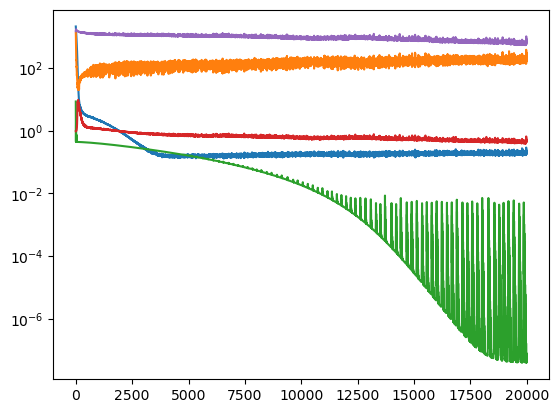

In [68]:
plt.plot(losses1)
plt.yscale('log')

In [312]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = params["D_A"]
D_B = params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [313]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        #Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            #tf.squeeze(Cg)
           )                               



def plot_state(pinn):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     #C, 
    ) = grads(pinn, H)

    A_der = D_A*( to(A_xx) + to(A_yy))
    B_der = D_B*( to(B_xx) + to(B_yy))

    actual_A_der = D_A*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = D_B*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der

    plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
      ["A", "Actual A", "B", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()

    A = c[0,:, : , -1]
    B = c[1,:, : , -1]
    print(np.sum((A_der-actual_A_der)**2))
    print(np.sum((B_der-actual_B_der)**2))


    plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
      ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
              ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    plot_n_im([A_der,  actual_A_der],
              ["RHS A", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der,  actual_B_der],
              ["RHS B", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

0.49956677440053177
896.8984796640713


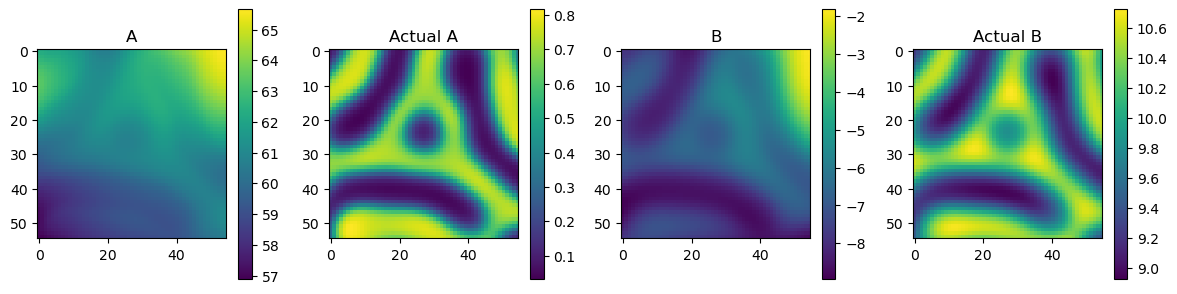

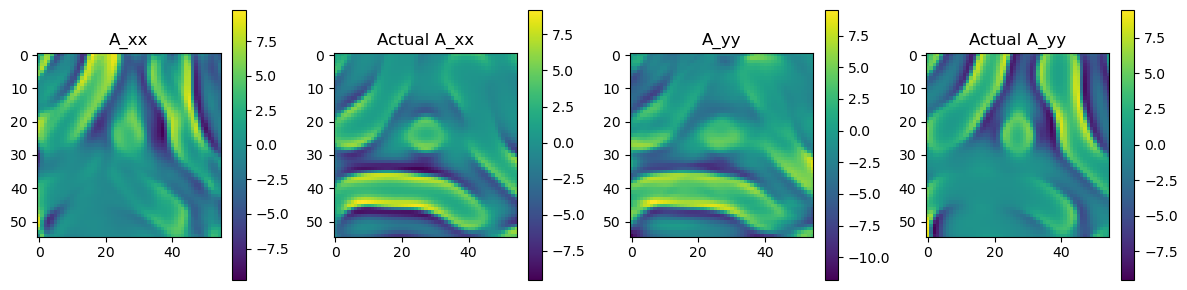

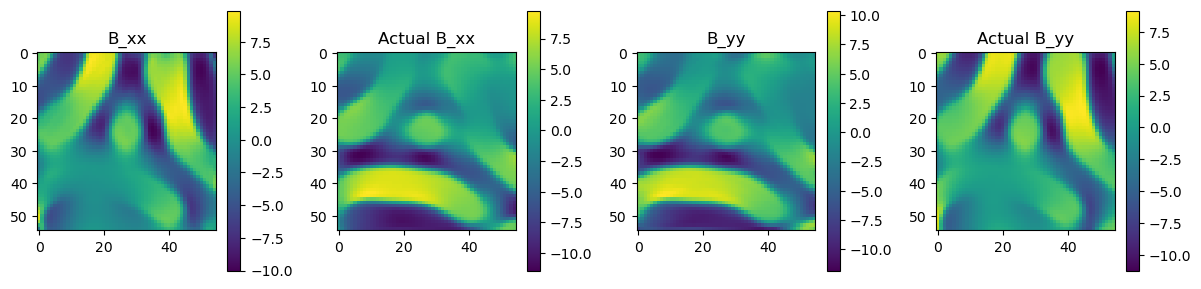

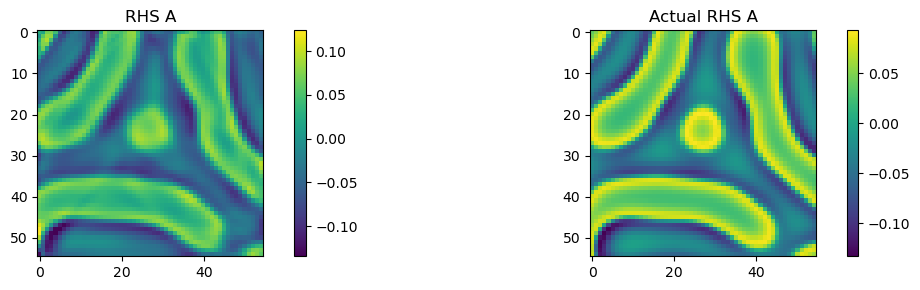

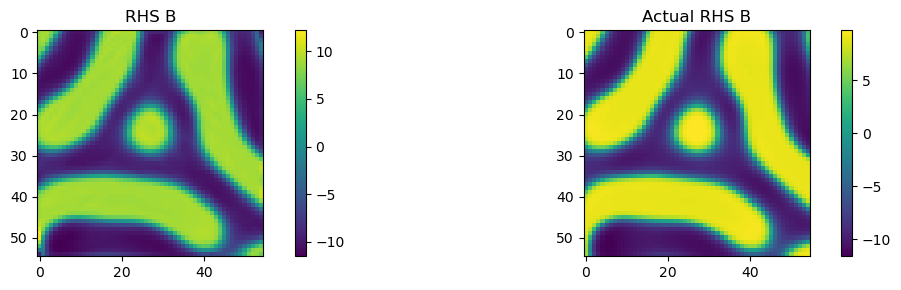

In [314]:
plot_state(pinn1)